# Figure 5

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import time
from copy import deepcopy
import dill as pickle

import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append("../model/")
sys.path.append('../../')
sys.path.append('../../simulator')

import viz
import helpers
from sbi_wrapper import simulate, simulate_energyscape, get_time
from sbi_prior import create_prior

from common import col, svg, samples_nd, get_labels_8pt
from conditional_density import eval_conditional_density, conditional_correlation, conditional_mutual_information, buildCondCovMatrix, partialCorrelation
import energy as ue

In [3]:
PANEL_A1 = '../svg/panel_a1.svg'
PANEL_A2 = '../svg/panel_a2.svg'
PANEL_A3 = '../svg/panel_a3.svg'
PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'
PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'
PANEL_C3 = '../svg/panel_c3.svg'
PANEL_D1 = '../svg/panel_d1.svg'
PANEL_D2 = '../svg/panel_d2.svg'
PANEL_D3 = '../svg/panel_d3.svg'
PANEL_D4 = '../svg/panel_d4.svg'
PANEL_D5 = '../svg/panel_d5.svg'

In [4]:
datafile = '../../results/prior_samples_after_classifier/samples_full_3.npz'
data = np.load(datafile)

params = data['params']
stats = data['stats']
seeds = data['seeds']

stats_mean = np.mean(stats, axis=0)
stats_std = np.std(stats, axis=0)

In [5]:
data = np.load('../../results/flow/200411_flow.npz', allow_pickle=True)
posterior = data['posterior'].tolist()

In [6]:
prior = create_prior(log=True)
dimensions = 31
params_mean = prior.mean.numpy()
params_std = prior.stddev.numpy()

npz = np.load('../../results/experimental_data/summstats_prep845_082_0044.npz')
summstats_experimental_11 = npz['summ_stats']

In [7]:
lims_unnorm = np.asarray([prior.support.lower_bound.numpy(), prior.support.upper_bound.numpy()]).T

In [8]:
lims = np.reshape([-np.sqrt(3), np.sqrt(3)]*46, (46,2))

### Find a value to condition on

In [9]:
data = np.load('../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz')
sample_stats = data['sample_stats']
sample_params = data['sample_params']
sample_seed = data['sample_seeds']
print('There are', len(sample_seed), 'datapoints in this dataset')

There are 55043 datapoints in this dataset


In [10]:
condition1 = sample_params[0] # 5,6 is good
condition_stats = sample_stats[0]

### Prepare data for plotting

In [11]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > len(params_mean) - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}$   ', r'$\mathdefault{10000}\;\;\;\;$   '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}$', r'$\mathdefault{1000}\;\;\;\;$ '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1] * params_std[dim_i] + params_mean[dim_i]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round(Decimal((lims[dim_i, num_tmp] * params_std[dim_i] + params_mean[dim_i]) / 0.628e-3), num_after_digits)
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}$')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$ ')
            counter+=1
        all_labels.append(new_labels)

In [12]:
condition1_norm = torch.as_tensor([condition1])

# Panel A: perturbing one parameter breaks activity

### Perturb parameter set

In [13]:
bad_condition = deepcopy(condition1)
bad_condition[10] = 0.005

../model/viz.py:445: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


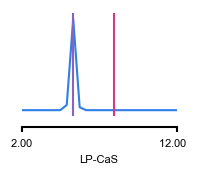

In [14]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    labels_[9] += ''

    fig, axes = viz.singleOneDmarginal(pdfs=[posterior],
                           samples=sample_params,
                           #subset=[0,1,2,3,4,5,6,7], # ,25,26,28
                           subset=[10], # ,25,26,28
                           limits=lims_unnorm,
                           ticks=lims_unnorm,
                           tick_labels=all_labels,
                           fig_size=(2, 1.4),
                           labels=labels_,
                           points=[condition1_norm, bad_condition],
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           #points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':3.6, 'markeredgewidth':0.5, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
                           points_colors=[col['CONSISTENT1'], col['INCONSISTENT']],
                           samples_colors=[col['SNPE']],
                           condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
                           diag=['cond'],
                           upper=['cond'],
                           hist_offdiag={'bins':40})
    #plt.savefig(PANEL_A1, facecolor='None', transparent=True)
    plt.show()

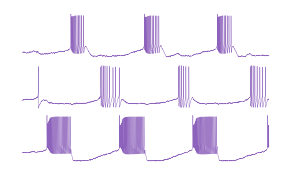

In [15]:
out_target = simulate(deepcopy(condition1), seed=0)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(3.5, 2.))
    fig = viz.vis_sample_plain(out_target, get_time(), ax, time_len=150000, col=col['CONSISTENT1'], scale_bar=False)
    #plt.savefig(PANEL_A2, facecolor='None', transparent=True)
    plt.show()

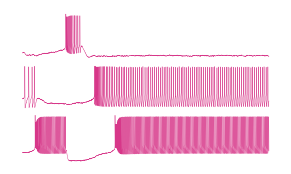

In [16]:
out_target = simulate(deepcopy(bad_condition), seed=0)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(3.5, 2.))
    fig = viz.vis_sample_plain(out_target, get_time(), ax, time_len=150000, col=col['INCONSISTENT'], scale_bar=False)
    #plt.savefig(PANEL_A3, facecolor='None', transparent=True)
    plt.show()

# Panel B: cure the parameter set

In [17]:
cured_condition = deepcopy(bad_condition)
cured_condition[11] = 0.033

In [19]:
def revert_positions(a):
    """
    Because we swap the dimensions of the two parameters (such that LP-CaS is on the x-axis), we also have to flip these values for the points.
    """
    a_new = deepcopy(a)
    a_new[10] = a[11]
    a_new[11] = a[10]
    return a_new

In [24]:
from sbi.utils import conditional_pairplot

In [42]:
condition1_norm

tensor([[ 1.7501e-01,  3.3116e-03,  3.2693e-03,  3.6443e-02,  5.9084e-03,
          6.5391e-02,  3.8488e-08,  3.8132e-06,  8.2712e-02,  8.5805e-05,
          3.3336e-03,  1.6879e-02,  2.7088e-03,  3.0673e-02,  2.0099e-06,
          2.3678e-05,  2.2869e-01,  7.3362e-03,  1.7211e-03,  2.2742e-02,
          2.8368e-04,  6.9616e-02,  1.9072e-05,  1.8384e-05, -1.7186e+01,
         -1.1649e+01, -1.0446e+01, -8.6075e+00, -1.0598e+01, -1.7504e+01,
         -1.0860e+01]])

In [43]:
lims_unnorm

array([[ 0.00000000e+00,  3.14000000e-01],
       [ 0.00000000e+00,  4.71000000e-03],
       [ 0.00000000e+00,  5.02400000e-03],
       [ 0.00000000e+00,  3.76800000e-02],
       [ 0.00000000e+00,  9.42000000e-03],
       [ 1.57000000e-02,  9.42000000e-02],
       [ 0.00000000e+00,  1.25600000e-05],
       [ 0.00000000e+00,  6.28000000e-06],
       [ 0.00000000e+00,  1.25600000e-01],
       [ 0.00000000e+00,  1.57000000e-03],
       [ 1.25600000e-03,  7.53600000e-03],
       [ 6.28000000e-03,  3.76800000e-02],
       [ 0.00000000e+00,  6.28000000e-03],
       [ 0.00000000e+00,  7.85000000e-02],
       [ 0.00000000e+00,  3.76800000e-05],
       [ 6.28000000e-06,  2.51200000e-05],
       [ 0.00000000e+00,  3.76800000e-01],
       [ 0.00000000e+00,  7.85000000e-03],
       [ 0.00000000e+00,  2.51200000e-03],
       [ 1.88400000e-02,  3.76800000e-02],
       [ 0.00000000e+00,  3.14000000e-03],
       [ 3.14000000e-02,  9.42000000e-02],
       [ 0.00000000e+00,  3.76800000e-05],
       [ 0.

In [ ]:
tensor([ 1.7501e-01,  3.3116e-03,  3.2693e-03,  3.6443e-02,  5.9084e-03,
         6.5391e-02,  3.8488e-08,  3.8132e-06,  8.2712e-02,  8.5805e-05,
         3.3336e-03,  1.6879e-02,  2.7088e-03,  3.0673e-02,  2.0099e-06,
         2.3678e-05,  2.2869e-01,  7.3362e-03,  1.7211e-03,  2.2742e-02,
         2.8368e-04,  6.9616e-02,  1.9072e-05,  1.8384e-05, -1.7186e+01,
        -1.1649e+01, -1.0446e+01, -8.6075e+00, -1.0598e+01, -1.7504e+01,
        -1.0860e+01])]

In [46]:
condition1_norm

tensor([[ 1.7501e-01,  3.3116e-03,  3.2693e-03,  3.6443e-02,  5.9084e-03,
          6.5391e-02,  3.8488e-08,  3.8132e-06,  8.2712e-02,  8.5805e-05,
          3.3336e-03,  1.6879e-02,  2.7088e-03,  3.0673e-02,  2.0099e-06,
          2.3678e-05,  2.2869e-01,  7.3362e-03,  1.7211e-03,  2.2742e-02,
          2.8368e-04,  6.9616e-02,  1.9072e-05,  1.8384e-05, -1.7186e+01,
         -1.1649e+01, -1.0446e+01, -8.6075e+00, -1.0598e+01, -1.7504e+01,
         -1.0860e+01]])

p_vector [4.9930476e-02 2.6740456e-01 2.1509850e-01 2.7616033e-01 4.7583896e-01
 4.5102620e+00 6.4390778e+01 1.2926328e+03 3.4164484e+04 9.7885231e+05
 2.9595718e+07 1.6008643e+09 1.4616809e+11 1.2926000e+13 6.3857211e+14
 9.0301859e+15 2.6905732e+16 1.6719410e+16 2.2204851e+15 1.4886768e+14
 8.3510024e+12 5.5504365e+11 3.1010060e+10 2.3274143e+09 3.0220586e+08
 5.7751408e+07 1.5914008e+07 3.8158958e+06 2.7734055e+06 2.0633958e+06
 2.3727442e+06 2.5262935e+06 2.4710315e+06 2.2555025e+06 1.8169991e+06
 1.3388924e+06 8.2372306e+05 5.1774297e+05 4.7719284e+05 5.7027600e+05
 6.3641212e+05 7.0758438e+05 7.0607975e+05 4.9368716e+05 3.7550288e+05
 3.1124344e+05 2.7422119e+05 2.0825073e+05 2.1871495e+05 2.0047152e+05]
p_vector [3.95319232e+08 4.95361184e+08 2.69662464e+08 7.07841920e+08
 2.69143603e+09 1.06576753e+10 4.37966356e+10 1.62373288e+11
 5.96493468e+11 2.08718319e+12 6.88319732e+12 2.68080555e+13
 1.23598447e+14 5.51862864e+14 2.29107568e+15 9.04149135e+15
 2.27063883e+16 2.95564789e

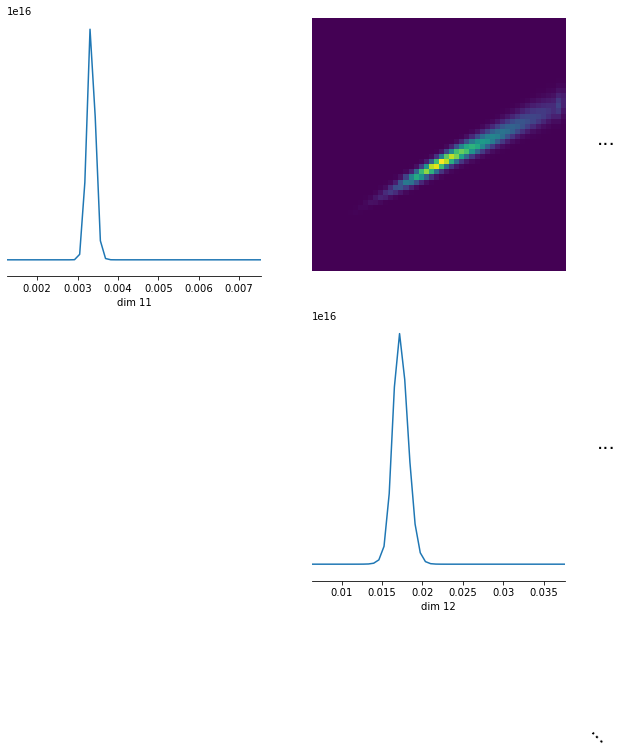

In [54]:
_ = conditional_pairplot(
    density=posterior,
    condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
    limits=torch.as_tensor(lims_unnorm),
    subset=[10, 11], 
)

../model/viz.py:756: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts['labels'] == [] or opts['labels'] is None:


yesa
lims [[ 0.00000000e+00  3.14000000e-01]
 [ 0.00000000e+00  4.71000000e-03]
 [ 0.00000000e+00  5.02400000e-03]
 [ 0.00000000e+00  3.76800000e-02]
 [ 0.00000000e+00  9.42000000e-03]
 [ 1.57000000e-02  9.42000000e-02]
 [ 0.00000000e+00  1.25600000e-05]
 [ 0.00000000e+00  6.28000000e-06]
 [ 0.00000000e+00  1.25600000e-01]
 [ 0.00000000e+00  1.57000000e-03]
 [ 1.25600000e-03  7.53600000e-03]
 [ 6.28000000e-03  3.76800000e-02]
 [ 0.00000000e+00  6.28000000e-03]
 [ 0.00000000e+00  7.85000000e-02]
 [ 0.00000000e+00  3.76800000e-05]
 [ 6.28000000e-06  2.51200000e-05]
 [ 0.00000000e+00  3.76800000e-01]
 [ 0.00000000e+00  7.85000000e-03]
 [ 0.00000000e+00  2.51200000e-03]
 [ 1.88400000e-02  3.76800000e-02]
 [ 0.00000000e+00  3.14000000e-03]
 [ 3.14000000e-02  9.42000000e-02]
 [ 0.00000000e+00  3.76800000e-05]
 [ 0.00000000e+00  2.51200000e-05]
 [-1.84206807e+01 -4.60517019e+00]
 [-1.84206807e+01 -6.90775528e+00]
 [-1.84206807e+01 -6.90775528e+00]
 [-1.84206807e+01 -6.90775528e+00]
 [-1.84206

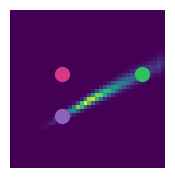

In [45]:
#condition1_swap = revert_positions(condition1)
#bad_condition_swap = revert_positions(bad_condition)
#cured_condition_swap = revert_positions(cured_condition)

with mpl.rc_context(fname='../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    labels_[9] += ''

    fig, axes = viz.single2Dmarginal(pdfs=[posterior],
                           samples=sample_params,
                           #subset=[0,1,2,3,4,5,6,7], # ,25,26,28
                           subset=[10, 11], # ,25,26,28
                           limits=lims_unnorm,
                           ticks=lims_unnorm,
                           tick_labels=all_labels,
                           fig_size=(2,2),
                           labels=labels_,
                           points=[condition1, bad_condition, cured_condition],
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           #points_offdiag={'marker':'o', 'markeredgecolor':'w', 'markersize':3.6, 'markeredgewidth':0.5, 'path_effects':[pe.Stroke(linewidth=1.2, foreground='k'), pe.Normal()]},
                           points_colors=[col['CONSISTENT1'], col['INCONSISTENT'], col['GT']],
                           samples_colors=[col['SNPE']],
                           condition=torch.as_tensor(condition1_norm, dtype=torch.float32),
                           diag=['cond'],
                           upper=['cond'],
                           hist_offdiag={'bins':40})
    
    #plt.savefig(PANEL_B1, facecolor='None', transparent=True)
    plt.show()

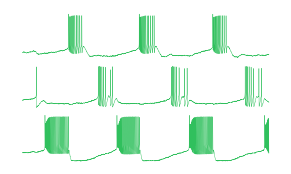

In [20]:
out_target = simulate(deepcopy(cured_condition), seed=0)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(3.5, 2.))
    fig = viz.vis_sample_plain(out_target, get_time(), ax, time_len=150000, col=col['GT'], scale_bar=False)
    #plt.savefig(PANEL_B2, facecolor='None', transparent=True)
    plt.show()

# Panel C: show that energy is not constant in this plane

In [21]:
pairs = np.asarray([[0,2], [4,5], [10,11], [11,12], [17,18], [18,19], [22,26], [24,25]]) #[18,19]
neuron_to_observe = ['PM', 'PM', 'LP', 'LP', 'PY', 'PY', 'PM', 'PM']

In [22]:
condition1_norm = torch.as_tensor([condition1], dtype=torch.float32)

In [23]:
condition1_norm

tensor([[ 1.7501e-01,  3.3116e-03,  3.2693e-03,  3.6443e-02,  5.9084e-03,
          6.5391e-02,  3.8488e-08,  3.8132e-06,  8.2712e-02,  8.5805e-05,
          3.3336e-03,  1.6879e-02,  2.7088e-03,  3.0673e-02,  2.0099e-06,
          2.3678e-05,  2.2869e-01,  7.3362e-03,  1.7211e-03,  2.2742e-02,
          2.8368e-04,  6.9616e-02,  1.9072e-05,  1.8384e-05, -1.7186e+01,
         -1.1649e+01, -1.0446e+01, -8.6075e+00, -1.0598e+01, -1.7504e+01,
         -1.0860e+01]])

In [24]:
grid_bins = 50

In [29]:
vec = np.linspace(-np.sqrt(3), np.sqrt(3), grid_bins)
all_energy_images = []
all_conditional_correlations = []

for counter, pair in enumerate(pairs):
    print('New pair')
    dim1 = pair[0]
    dim2 = pair[1]
    
    p_vector = eval_conditional_density(posterior, condition1_norm, lims_unnorm,
                                    dim1, dim2, resolution=50, log=False)
    p_vector = p_vector / np.max(p_vector) # just to scale it to 1
    
    # get the minimum requried probability to be simulated
    min_prob = ue.extract_min_prob(posterior, condition1_norm, grid_bins, dim1, dim2, lims_unnorm, mode='posterior_prob')
    min_prob /= 10000
    # get the energies in the conditional plane
    energy_image, spike_width = ue.energy_of_conditional(posterior, pyloric_sim, energy_calc, condition1_norm, grid_bins, min_prob,
                                            dim1, dim2, lims_unnorm, stats_std=stats_std, neuron_to_observe=neuron_to_observe[counter], mode='total')

New pair


KeyboardInterrupt: 

In [25]:
# small adjustments for plotting
diff_energy = np.max(energy_image[energy_image > 0.0]) - np.min(energy_image[energy_image > 0.0])
#energy_image[energy_image == 0.0] = np.min(energy_image[energy_image > 0.0]) - diff_energy
energy_image[energy_image == -1.0] = -np.max(energy_image)

#spike_width[np.isnan(spike_width)] = 0.0
#diff_width = np.max(spike_width[spike_width != 0.0]) - np.min(spike_width[spike_width != 0.0])
#spike_width[spike_width == 0.0] = np.min(spike_width[spike_width != 0.0]) - diff_width

all_conditional_correlations.append(p_vector)
all_energy_images.append(energy_image)

NameError: name 'energy_image' is not defined

In [26]:
#np.save('../results/energy/conditional_correlation_energy/200514_energy_condCorrRejection_grid50', all_conditional_correlations)
#np.save('../results/energy/conditional_correlation_energy/200514_energy_condCorrRejection_grid50_energy', all_energy_images)

In [27]:
all_conditional_correlations = np.load('../../results/conditional_correlation_energy/200514_energy_condCorrRejection_grid50.npy')
all_energy_images = np.load('../../results/conditional_correlation_energy/200514_energy_condCorrRejection_grid50_energy.npy')

In [28]:
all_conditional_correlations = np.asarray(all_conditional_correlations)
all_energy_images = np.asarray(all_energy_images)

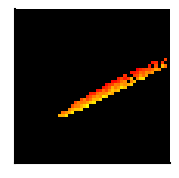

In [29]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 128))
whites = np.ones_like(colors)
whites[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((whites, np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,2))
    h = ax.imshow(all_energy_images[2], origin='lower', aspect='auto', cmap=mymap)
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.get_xaxis().set_ticks([])
    #plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

In [30]:
neurons = ['AB/PD1', 'AB/PD2', 'LP1', 'LP2', 'PY1', 'PY2', 'syn1', 'syn2']

seeds_max = [0, 0, 0, 1, 0, 0, 0, 0]
seeds_min = [0, 0, 1, 1, 0, 0, 0, 0]

t_max_mins = [125000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_max_maxs = [145000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

t_min_mins = [120000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_min_maxs = [140000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

neuron_to_plot = [0,0,1,1,2,2,2,0]
    
# find dims
energy_image = all_energy_images[2]
pair = pairs[2]
dim1 = pair[0]
dim2 = pair[1]

vec1 = np.linspace(lims_unnorm[dim1, 0], lims_unnorm[dim1, 1], grid_bins)
vec2 = np.linspace(lims_unnorm[dim2, 0], lims_unnorm[dim2, 1], grid_bins)

-------- High energy set --------


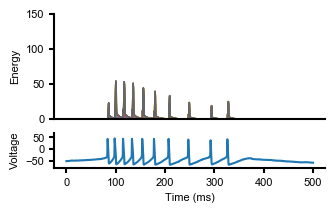

In [31]:
###################################################################################################
#                                        maximum energy set                                       #
###################################################################################################

print('-------- High energy set --------')
cond1_norm_tmp = deepcopy(condition1_norm[0])
tmp_energy_image = deepcopy(energy_image)
# find parameter value that had maximum energy
max_energy_pixel = np.unravel_index(tmp_energy_image.argmax(), tmp_energy_image.shape)

# replace the parameter values
param1 = vec1[max_energy_pixel[0]]
param2 = vec2[max_energy_pixel[1]]

cond1_norm_tmp[dim1] = param1
cond1_norm_tmp[dim2] = param2

# simulate and build energy scape
parameter_set = cond1_norm_tmp

out_target = simulate_energyscape(deepcopy(parameter_set), seed=8607175)

with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.plot_energy_scape(out_target, get_time(), neuron_to_plot[2], t_max_mins[2], t_max_maxs[2], figsize=(3.5, 2.))
    #plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

-------- Low energy set --------


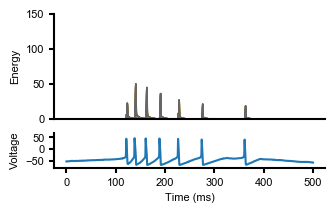

max_energy_pixel (26, 31) min_energy_pixel (18, 23)


In [32]:
###################################################################################################
#                                        minimum energy set                                       #
###################################################################################################
print('-------- Low energy set --------')
tmp_energy_image = deepcopy(energy_image)
tmp_energy_image[tmp_energy_image == np.min(tmp_energy_image)] = 1e10
min_energy_pixel = np.unravel_index(tmp_energy_image.argmin(), tmp_energy_image.shape)

param1 = vec1[min_energy_pixel[0]]
param2 = vec2[min_energy_pixel[1]]

cond1_norm_tmp[dim1] = param1
cond1_norm_tmp[dim2] = param2

parameter_set = cond1_norm_tmp

out_target = simulate_energyscape(deepcopy(parameter_set), seed=8607175)

with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.plot_energy_scape(out_target, get_time(), neuron_to_plot[2], t_min_mins[2], t_min_maxs[2], figsize=(3.5, 2.))
    #plt.savefig(PANEL_C3, facecolor='None', transparent=True)
    plt.show()
print('max_energy_pixel', max_energy_pixel, 'min_energy_pixel', min_energy_pixel)

# Panel D: summarize the energy gains in matrizes

In [33]:
grid_bins = 20

### AB/PD

In [34]:
# helpers.generate_and_store_data(
#     neuron1=np.arange(8),
#     neuron2=np.arange(8),
#     neuron_to_observe='PM',
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm,
#     lims_unnorm=lims_unnorm,
#     pyloric_sim=pyloric_sim,
#     energy_calc=energy_calc,
#     stats_std=stats_std
# )

In [35]:
with open('../../results/conditional_correlation_energy/200703_PM_all_stored_data_from_energy_all_energy_images.pickle', 'rb') as handle:
    all_energy_images = pickle.load(handle)

np.ma 0.14891238703550472


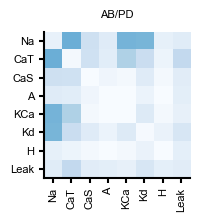

In [36]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.energy_gain_matrix(all_energy_images, figsize=(1.9,1.9), title='AB/PD')
    #plt.savefig(PANEL_D1, facecolor='None', transparent=True)
    plt.show()

### LP

In [37]:
# helpers.generate_and_store_data(
#    neuron1=np.arange(8,16),
#    neuron2=np.arange(8,16),
#    neuron_to_observe='LP',
#    grid_bins=grid_bins,
#    posterior=posterior,
#    condition1_norm=condition1_norm,
#    lims_unnorm=lims_unnorm,
#    pyloric_sim=pyloric_sim,
#    energy_calc=energy_calc,
#    stats_std=stats_std
# )

In [38]:
with open('../../results/conditional_correlation_energy/200703_LP_all_stored_data_from_energy_all_energy_images.pickle', 'rb') as handle:
    all_energy_images = pickle.load(handle)

np.ma 0.12631526140393928


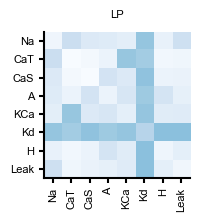

In [39]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.energy_gain_matrix(all_energy_images, figsize=(1.9,1.9), title='LP')
    #plt.savefig(PANEL_D2, facecolor='None', transparent=True)
    plt.show()

### PY

In [40]:
# helpers.generate_and_store_data(
#     neuron1=np.arange(16,24),
#     neuron2=np.arange(16,24),
#     neuron_to_observe='PY',
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm,
#     lims_unnorm=lims_unnorm,
#     pyloric_sim=pyloric_sim,
#     energy_calc=energy_calc,
#     stats_std=stats_std
# )

In [41]:
with open('../../results/conditional_correlation_energy/200703_PY_all_stored_data_from_energy_all_energy_images.pickle', 'rb') as handle:
    all_energy_images = pickle.load(handle)

np.ma 0.3009912748551449


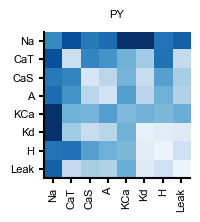

In [42]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    im = viz.energy_gain_matrix(all_energy_images, figsize=(1.9,1.9), title='PY')
    fig.colorbar(im)
    #plt.savefig(PANEL_D3, facecolor='None', transparent=True)
    plt.show()

### Synapses

In [43]:
pairs = np.asarray([[24, 8], [24, 9], [24, 10], [24, 11], [24, 12], [24, 13], [24, 14], [24, 15], #LP
                    [25, 8], [25, 9], [25, 10], [25, 11], [25, 12], [25, 13], [25, 14], [25, 15], #LP
                    [26, 16], [26, 17], [26, 18], [26, 19], [26, 20], [26, 21], [26, 22], [26, 23], #PY
                    [27, 16], [27, 17], [27, 18], [27, 19], [27, 20], [27, 21], [27, 22], [27, 23], #PY
                    [28, 0], [28, 1], [28, 2], [28, 3], [28, 4], [28, 5], [28, 6], [28, 7], #PD
                    [29, 16], [29, 17], [29, 18], [29, 19], [29, 20], [29, 21], [29, 22], [29, 23], #PY
                    [30, 8], [30, 9], [30, 10], [30, 11], [30, 12], [30, 13], [30, 14], [30, 15]] #LP
)
neuron_to_observe = ['LP']*16 +['PY']*16 + ['PM']*8 + ['PY']*8 + ['LP']*8

# helpers.generate_and_store_data(
#     pairs=pairs,
#     neuron1=np.arange(16,24),
#     neuron2=np.arange(16,24),
#     neuron_to_observe=neuron_to_observe,
#     grid_bins=grid_bins,
#     posterior=posterior,
#     condition1_norm=condition1_norm,
#     lims_unnorm=lims_unnorm,
#     pyloric_sim=pyloric_sim,
#     energy_calc=energy_calc,
#     stats_std=stats_std,
#     store_as='Synapses'
# )

In [44]:
with open('../../results/conditional_correlation_energy/200703_Synapses_all_stored_data_from_energy_all_energy_images.pickle', 'rb') as handle:
    all_energy_images = pickle.load(handle)

np.ma 0.22544741964573964


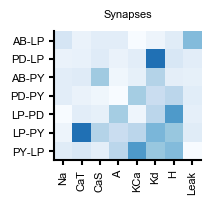

In [45]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    im = viz.energy_gain_matrix_syn(all_energy_images, figsize=(1.9,1.9), title='Synapses')
    fig.colorbar(im)
    #plt.savefig(PANEL_D4, facecolor='None', transparent=True)
    plt.show()

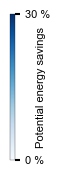

In [46]:
with mpl.rc_context(fname='../../.matplotlibrc'):

    # draw a new figure and replot the colorbar there
    fig,ax = plt.subplots(figsize=(1.9,1.9))
    cb = plt.colorbar(im,ax=ax, aspect=30)

    #cb.outline.set_color('white')
    
    cb.outline.set_edgecolor('k')
    cb.outline.set_linewidth(0.2)

    cb.set_ticks([0., 30])  # vertically oriented colorbar
    cb.ax.set_yticklabels(['0 %', '30 %'])  # vertically oriented colorbar
                           
    cb.ax.set_ylabel('Potential energy savings')
    cb.ax.yaxis.labelpad = -10
    
    ax.remove()
    #plt.savefig(PANEL_D5, facecolor='None', transparent=True)
    plt.show()

# Assemble figure

In [47]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [84]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "19.0cm",

    Panel(
          SVG(PANEL_A1).scale(svg_scale),
          Text("a", 0*factor_svg, 2*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 0.4*factor_svg),
           
    Panel(
        SVG(PANEL_A2).scale(svg_scale),
    ).move(30*factor_svg, -2.5*factor_svg),
           
    Panel(
        SVG(PANEL_A3).scale(svg_scale),
    ).move(80*factor_svg, -2.5*factor_svg),
    
    Panel(
        SVG(PANEL_B1).scale(svg_scale),
        Text("b", 0*factor_svg, 0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 30*factor_svg),
    
    Panel(
        SVG(PANEL_B2).scale(svg_scale),
    ).move(30*factor_svg, 30*factor_svg),
           
    Panel(
        SVG(PANEL_C1).scale(svg_scale),
        Text("c", 0*factor_svg, 0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 60*factor_svg),
    
    Panel(
        SVG(PANEL_C2).scale(svg_scale),
    ).move(30*factor_svg, 60*factor_svg),
    
    Panel(
        SVG(PANEL_C3).scale(svg_scale),
    ).move(85*factor_svg, 60*factor_svg),
           
    Panel(
        SVG(PANEL_D1).scale(svg_scale),
        Text("d", 0*factor_svg, 0*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 95*factor_svg),
    
    Panel(
        SVG(PANEL_D2).scale(svg_scale),
    ).move(32*factor_svg, 95*factor_svg),
    
    Panel(
        SVG(PANEL_D3).scale(svg_scale),
    ).move(64*factor_svg, 95*factor_svg),
           
    Panel(
        SVG(PANEL_D4).scale(svg_scale),
    ).move(96*factor_svg, 95*factor_svg),
           
    Panel(
        SVG(PANEL_D5).scale(svg_scale),
    ).move(131*factor_svg, 98*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig5.svg")
svg('../fig/fig5.svg')

# Old stuff

### All 8 conditional correlations

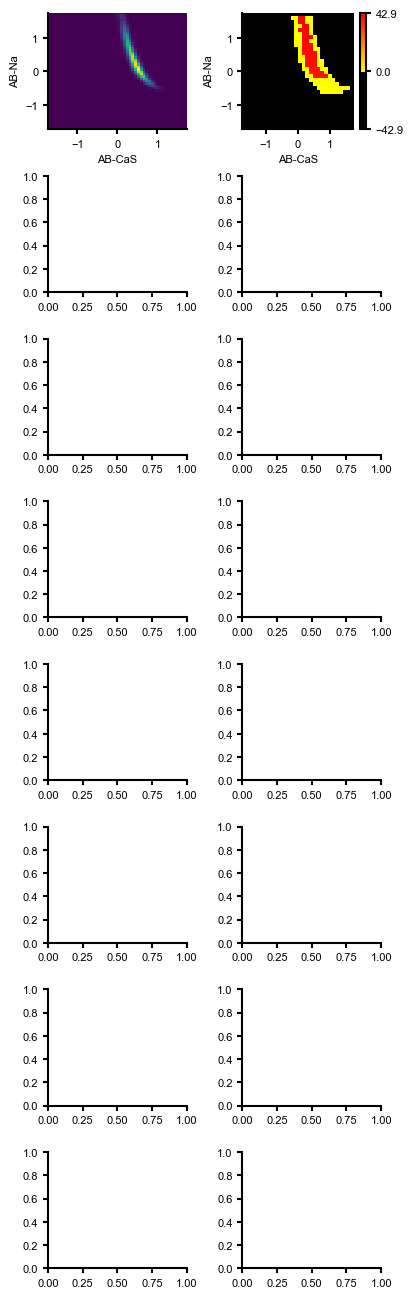

In [154]:
# build colormap
colors = plt.cm.autumn(np.linspace(0, 1, 128))
whites = np.ones_like(colors)
whites[:, :3] = 0.0

# combine them and build a new colormap
colors = np.vstack((whites, np.flipud(colors)))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
index = 0

with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(8, 2, figsize=(4.3, 16.3))
    
    for condCorr, energy in zip(all_conditional_correlations, all_energy_images):
        
        energy = energy/100000
        pair = pairs[index]
        dim1 = pair[0]
        dim2 = pair[1]
        
        # plotting conditional correlations
        _ = ax[index, 0].imshow(condCorr, origin='lower',
                        extent=[lims[dim1, 0], lims[dim1, 1], lims[dim2, 0], lims[dim2, 1]],
                        aspect='auto'
        )
        ax[index, 0].set_xlabel(labels_[dim2])
        ax[index, 0].set_ylabel(labels_[dim1])
        
        # plotting the energy
        h = ax[index, 1].imshow(energy, origin='lower',
                        extent=[lims[dim1, 0], lims[dim1, 1], lims[dim2, 0], lims[dim2, 1]],
                        aspect='auto', cmap=mymap
        )
        cbar = fig.colorbar(h, ax=ax[index, 1], ticks=[np.min(energy), (np.max(energy) + np.min(energy))/2, np.max(energy)])

        str1 = str(  round(  float(    (np.max(energy) + np.min(energy))/2)   , 2  )   )
        str2 = str(  round(  float(np.max(energy)), 2)   )   

        #cbar.ax.set_yticklabels(['/', str1, str2])  # vertically oriented colorbar

        ax[index, 1].set_xlabel(labels_[dim2])
        ax[index, 1].set_ylabel(labels_[dim1])
        
        index += 1
        
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    #plt.savefig('../results/energy/figs_new/energy_heatmap_full_rejectionNew.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Compute the energy-scape for the min and max of the sample

In [72]:
condition1_norm = condition1

In [74]:
def plot_energy_scape(pyloric_sim, parameter_set, neuron_to_plot, t_min, t_max, seed, index, minmax):
    #print('parameter_set', parameter_set)
    out_target = pyloric_sim[0].gen_single(deepcopy(parameter_set), seed_sim=True, to_seed=8607175) # params.true_params gives the synaptic strengths #  165000
    ss = energy_calc.calc([out_target])[0]
    #print('First 4 summstats:  ', ss[:4])
    #print('energies', np.sum(out_target['energy'][:,40000:], axis=1)/10000)
    print(offsets[all_counter])
    #fig = viz_samples.vis_sample(pyloric_sim[0], summ_stats, parameter_set, voltage_trace=out_target, test_idx=[0], case='high_p', hyperparams=params,
    #                             offset_labels=1000, with_ss=False, time_len=500000, fontscale=1.2, linescale=1.2, legend=False, offset=165000,
    #                             mode='31D', mem_dimensions=[0,1,8,14,19,21], title='Sample along the path of high probability in Prinz format', date_today='190906_31D_samples_small', counter=counter, mode2='small', scale_bar=False, save_fig=False)
    #plt.show()
    # build energyscape
    all_energies = out_target['all_energies']
    all_currents_PD = all_energies[:,neuron_to_plot,:]
    zero_val = np.zeros_like(all_currents_PD)
    t = pyloric_sim_11[0].t[0:t_max-t_min]
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 3), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(8):
        #ax[0].plot(t, all_currents_PD[i,t_min:t_max])
        summed_currents_until   = np.sum(all_currents_PD[:i, t_min:t_max], axis=0)
        summed_currents_include = np.sum(all_currents_PD[:i+1, t_min:t_max], axis=0)
        ax[0].fill_between(t, summed_currents_until, summed_currents_include, color=cols_hex[i])

    ax[0].set_ylim([0, 150])
    ax[1].plot(t, out_target['data'][neuron_to_plot,t_min:t_max])
    ax[1].set_ylim([-80, 70])
    
    #print('summed_currents_include', np.sum(summed_currents_include))

    for a in ax:
        a.set_ylabel('Energy', fontsize=12.0)
        if a == ax[1]: a.set_xlabel('Time (ms)', fontsize=12.0)
        a.tick_params(axis='both', which='major', labelsize=12)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        
    ax[0].axes.get_xaxis().set_ticks([])
    ax[1].set_ylabel('Voltage', fontsize=12.0)
    
    plt.show()

====================== AB/PD1 =====================
-------- High energy set --------
95000


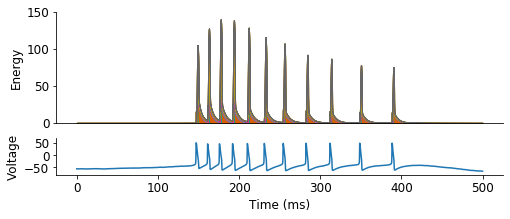

-------- Low energy set --------
95000


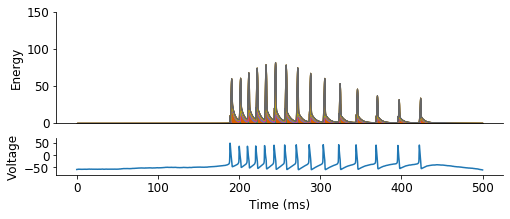

max_energy_pixel (41, 28) min_energy_pixel (21, 33)
====================== AB/PD2 =====================
-------- High energy set --------
95000


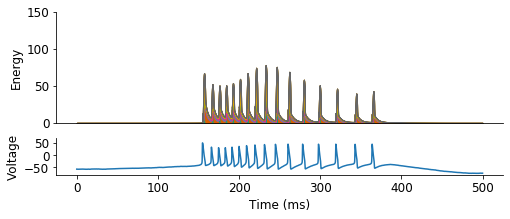

-------- Low energy set --------
95000


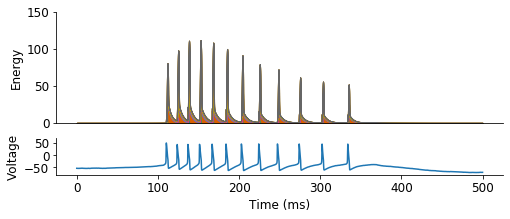

max_energy_pixel (23, 10) min_energy_pixel (34, 47)
====================== LP1 =====================
-------- High energy set --------
95000


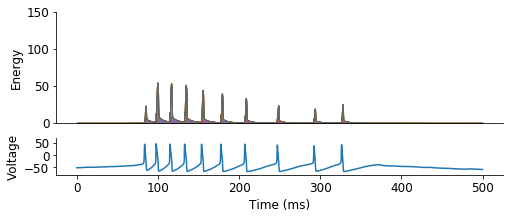

-------- Low energy set --------
95000


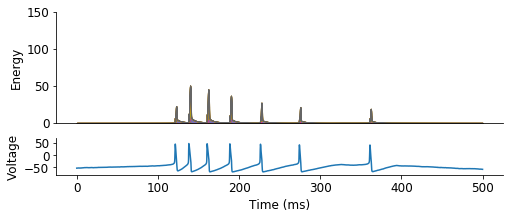

max_energy_pixel (26, 31) min_energy_pixel (18, 23)
====================== LP2 =====================
-------- High energy set --------
95000


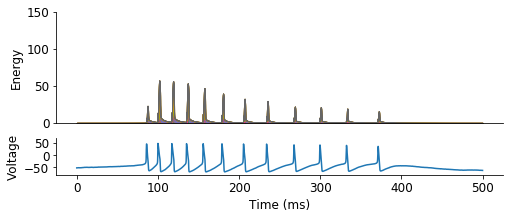

-------- Low energy set --------
95000


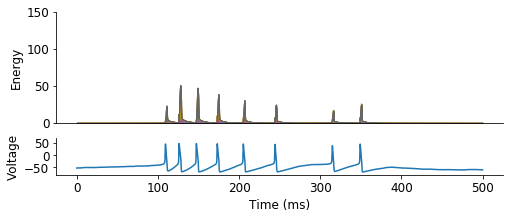

max_energy_pixel (9, 48) min_energy_pixel (18, 31)
====================== PY1 =====================
-------- High energy set --------
95000


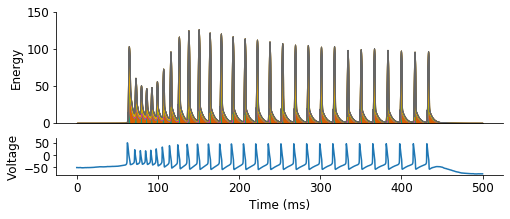

-------- Low energy set --------
95000


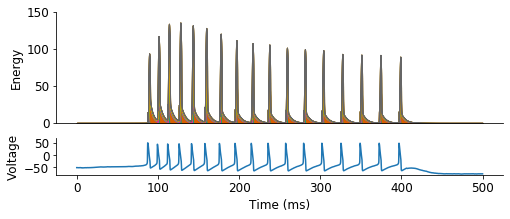

max_energy_pixel (46, 40) min_energy_pixel (22, 42)
====================== PY2 =====================
-------- High energy set --------
95000


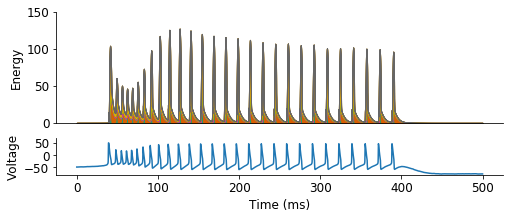

-------- Low energy set --------
95000


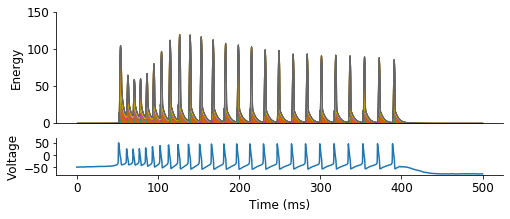

max_energy_pixel (36, 1) min_energy_pixel (48, 45)
====================== syn1 =====================
-------- High energy set --------
95000


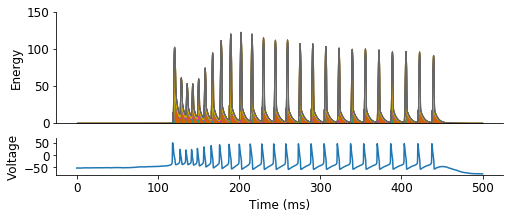

-------- Low energy set --------
95000


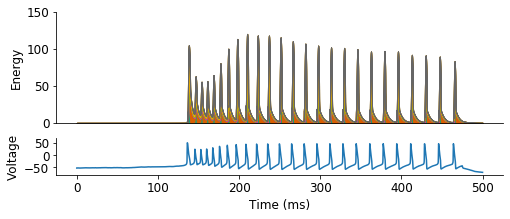

max_energy_pixel (29, 28) min_energy_pixel (39, 46)
====================== syn2 =====================
-------- High energy set --------
95000


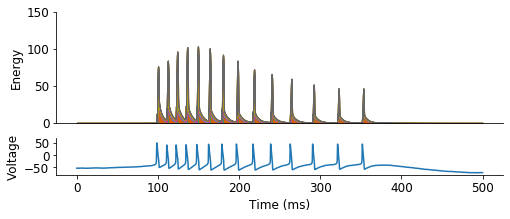

-------- Low energy set --------
95000


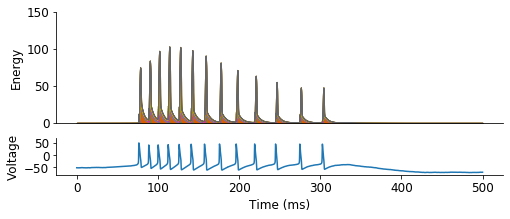

max_energy_pixel (27, 28) min_energy_pixel (5, 28)


In [75]:
cols_hex = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#e6ab02', '#a6761d', '#666666']
t_min = 72000
t_max = 100000

neurons = ['AB/PD1', 'AB/PD2', 'LP1', 'LP2', 'PY1', 'PY2', 'syn1', 'syn2']

seeds_max = [0, 0, 0, 1, 0, 0, 0, 0]
seeds_min = [0, 0, 1, 1, 0, 0, 0, 0]

t_max_mins = [125000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_max_maxs = [145000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

t_min_mins = [120000, 125000, 100000, 100000, 112000, 113000, 110000, 125000]
t_min_maxs = [140000, 145000, 120000, 120000, 132000, 133000, 130000, 145000]

neuron_to_plot = [0,0,1,1,2,2,2,0]

for index, energy_image in enumerate(all_energy_images):
    
        print('======================', neurons[index], '=====================')
        # find dims
        pair = pairs[index]
        dim1 = pair[0]
        dim2 = pair[1]

        vec1 = np.linspace(lims_unnorm[dim1, 0], lims_unnorm[dim1, 1], grid_bins)
        vec2 = np.linspace(lims_unnorm[dim2, 0], lims_unnorm[dim2, 1], grid_bins)

        ###################################################################################################
        #                                        maximum energy set                                       #
        ###################################################################################################

        print('-------- High energy set --------')
        cond1_norm_tmp = deepcopy(condition1_norm)
        tmp_energy_image = deepcopy(energy_image)
        # find parameter value that had maximum energy
        max_energy_pixel = np.unravel_index(tmp_energy_image.argmax(), tmp_energy_image.shape)

        # replace the parameter values
        param1 = vec1[max_energy_pixel[0]]
        param2 = vec2[max_energy_pixel[1]]

        cond1_norm_tmp[dim1] = param1
        cond1_norm_tmp[dim2] = param2

        # simulate and build energy scape
        parameter_set = cond1_norm_tmp
        plot_energy_scape(pyloric_sim, parameter_set, neuron_to_plot[index], t_max_mins[index], t_max_maxs[index],
                          seeds_max[index], index, 'max')

        ###################################################################################################
        #                                        minimum energy set                                       #
        ###################################################################################################
        print('-------- Low energy set --------')
        cond1_norm_tmp = deepcopy(condition1_norm)
        tmp_energy_image = deepcopy(energy_image)
        tmp_energy_image[tmp_energy_image == np.min(tmp_energy_image)] = 1e10
        min_energy_pixel = np.unravel_index(tmp_energy_image.argmin(), tmp_energy_image.shape)

        param1 = vec1[min_energy_pixel[0]]
        param2 = vec2[min_energy_pixel[1]]

        cond1_norm_tmp[dim1] = param1
        cond1_norm_tmp[dim2] = param2

        parameter_set = cond1_norm_tmp
        plot_energy_scape(pyloric_sim, parameter_set, neuron_to_plot[index], t_min_mins[index], t_min_maxs[index],
                          seeds_min[index], index, 'min')

        plt.show()

        print('max_energy_pixel', max_energy_pixel, 'min_energy_pixel', min_energy_pixel)